In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")
raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/T.csv")

dataset = raw_dataset.copy()

#examine missing data
# dataset.head()

2.6.0


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

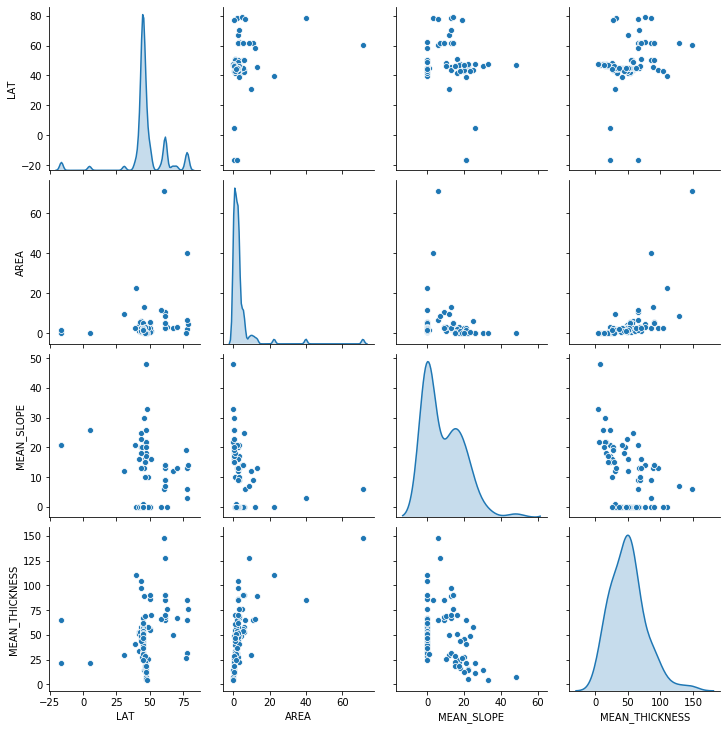

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Linear regression with area

In [8]:
#put training features into numpy array and create normalization layer
# array_int = np.array(train_features)
area = np.array(train_features["AREA"])
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)

In [9]:
#build elevation model with Sequential
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(1)
])

# area_model.summary()

In [10]:
#more pfm
area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [11]:
#run the actual model
#%%time
history_area = area_model.fit(
    train_features["AREA"], train_labels,
    epochs=100,
    # suppress logging
#    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/300
3/3 [==============================] - 0s 55ms/step - loss: 48.8332 - val_loss: 56.3581
Epoch 2/300
3/3 [==============================] - 0s 11ms/step - loss: 48.5251 - val_loss: 56.0790
Epoch 3/300
3/3 [==============================] - 0s 8ms/step - loss: 48.2181 - val_loss: 55.7917
Epoch 4/300
3/3 [==============================] - 0s 11ms/step - loss: 47.9202 - val_loss: 55.5087
Epoch 5/300
3/3 [==============================] - 0s 9ms/step - loss: 47.6117 - val_loss: 55.2157
Epoch 6/300
3/3 [==============================] - 0s 12ms/step - loss: 47.3102 - val_loss: 54.9194
Epoch 7/300
3/3 [==============================] - 0s 9ms/step - loss: 47.0112 - val_loss: 54.6231
Epoch 8/300
3/3 [==============================] - 0s 12ms/step - loss: 46.7084 - val_loss: 54.3215
Epoch 9/300
3/3 [==============================] - 0s 9ms/step - loss: 46.4108 - val_loss: 54.0177
Epoch 10/300
3/3 [==============================] - 0s 12ms/step - loss: 46.1100 - val_loss: 53.7159
Epo

3/3 [==============================] - 0s 10ms/step - loss: 27.3805 - val_loss: 35.4180
Epoch 83/300
3/3 [==============================] - 0s 10ms/step - loss: 27.1787 - val_loss: 35.2226
Epoch 84/300
3/3 [==============================] - 0s 10ms/step - loss: 26.9761 - val_loss: 35.0272
Epoch 85/300
3/3 [==============================] - 0s 9ms/step - loss: 26.7802 - val_loss: 34.8321
Epoch 86/300
3/3 [==============================] - 0s 9ms/step - loss: 26.5705 - val_loss: 34.6386
Epoch 87/300
3/3 [==============================] - 0s 9ms/step - loss: 26.3602 - val_loss: 34.4459
Epoch 88/300
3/3 [==============================] - 0s 11ms/step - loss: 26.1913 - val_loss: 34.2531
Epoch 89/300
3/3 [==============================] - 0s 9ms/step - loss: 25.9843 - val_loss: 34.0557
Epoch 90/300
3/3 [==============================] - 0s 11ms/step - loss: 25.8142 - val_loss: 33.8629
Epoch 91/300
3/3 [==============================] - 0s 13ms/step - loss: 25.6276 - val_loss: 33.6754
Epoch 9

Epoch 163/300
3/3 [==============================] - 0s 15ms/step - loss: 18.4492 - val_loss: 24.4560
Epoch 164/300
3/3 [==============================] - 0s 12ms/step - loss: 18.4103 - val_loss: 24.3831
Epoch 165/300
3/3 [==============================] - 0s 15ms/step - loss: 18.3714 - val_loss: 24.3172
Epoch 166/300
3/3 [==============================] - 0s 14ms/step - loss: 18.3461 - val_loss: 24.2492
Epoch 167/300
3/3 [==============================] - 0s 13ms/step - loss: 18.3075 - val_loss: 24.1801
Epoch 168/300
3/3 [==============================] - 0s 11ms/step - loss: 18.2691 - val_loss: 24.1076
Epoch 169/300
3/3 [==============================] - 0s 11ms/step - loss: 18.2356 - val_loss: 24.0369
Epoch 170/300
3/3 [==============================] - 0s 11ms/step - loss: 18.1969 - val_loss: 23.9741
Epoch 171/300
3/3 [==============================] - 0s 11ms/step - loss: 18.1656 - val_loss: 23.9115
Epoch 172/300
3/3 [==============================] - 0s 19ms/step - loss: 18.1303 

3/3 [==============================] - 0s 9ms/step - loss: 16.5190 - val_loss: 20.6635
Epoch 244/300
3/3 [==============================] - 0s 10ms/step - loss: 16.5023 - val_loss: 20.6231
Epoch 245/300
3/3 [==============================] - 0s 9ms/step - loss: 16.4806 - val_loss: 20.5881
Epoch 246/300
3/3 [==============================] - 0s 9ms/step - loss: 16.4845 - val_loss: 20.5520
Epoch 247/300
3/3 [==============================] - 0s 12ms/step - loss: 16.4788 - val_loss: 20.5255
Epoch 248/300
3/3 [==============================] - 0s 9ms/step - loss: 16.4727 - val_loss: 20.4956
Epoch 249/300
3/3 [==============================] - 0s 10ms/step - loss: 16.4681 - val_loss: 20.4653
Epoch 250/300
3/3 [==============================] - 0s 9ms/step - loss: 16.4662 - val_loss: 20.4308
Epoch 251/300
3/3 [==============================] - 0s 8ms/step - loss: 16.4539 - val_loss: 20.4064
Epoch 252/300
3/3 [==============================] - 0s 9ms/step - loss: 16.4478 - val_loss: 20.3892
E

In [12]:
hist_area = pd.DataFrame(history_area.history)
hist_area['epoch'] = history_area.epoch
hist_area.tail()

,loss,val_loss,epoch
295,16.232986,19.546373,295
296,16.231800,19.528358,296
297,16.228748,19.514872,297
298,16.228802,19.504230,298
299,16.225950,19.494740,299


In [13]:
area_test_results = {}

area_test_results['area_model'] = area_model.evaluate(
    test_features['AREA'],
    test_labels, verbose=0)

area_test_results['area_model']

69.71702575683594

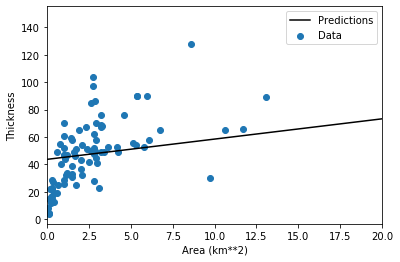

In [14]:
def plot_area(x, y):
    plt.scatter(train_features['AREA'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_area(x,y)

# Linear regression with latitude

In [15]:
#put training features into numpy array and apply normalization layer
# array_int = np.array(train_features)
lat = np.array(train_features["LAT"])
lat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lat_normalizer.adapt(lat)

In [16]:
#build latitude model with Sequential
lat_model = tf.keras.Sequential([
    lat_normalizer,
    layers.Dense(1)
])

# area_model.summary()

In [17]:
#more pfm
lat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [18]:
#run the actual model
#%%time
history_lat = lat_model.fit(
    train_features["LAT"], train_labels,
    epochs=100,
    # suppress logging
#    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
3/3 [==============================] - 0s 44ms/step - loss: 48.8166 - val_loss: 56.4747
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 48.4975 - val_loss: 56.1781
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 48.1896 - val_loss: 55.9270
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 47.8803 - val_loss: 55.6881
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 47.5618 - val_loss: 55.4449
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 47.2534 - val_loss: 55.2023
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 46.9361 - val_loss: 54.9569
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 46.6176 - val_loss: 54.7065
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 46.3039 - val_loss: 54.4643
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 45.9947 - val_loss: 54.2212
E

3/3 [==============================] - 0s 10ms/step - loss: 29.2685 - val_loss: 35.0302
Epoch 83/100
3/3 [==============================] - 0s 9ms/step - loss: 29.1078 - val_loss: 34.7906
Epoch 84/100
3/3 [==============================] - 0s 9ms/step - loss: 28.9345 - val_loss: 34.5627
Epoch 85/100
3/3 [==============================] - 0s 11ms/step - loss: 28.7607 - val_loss: 34.3275
Epoch 86/100
3/3 [==============================] - 0s 9ms/step - loss: 28.6138 - val_loss: 34.0719
Epoch 87/100
3/3 [==============================] - 0s 9ms/step - loss: 28.4563 - val_loss: 33.8245
Epoch 88/100
3/3 [==============================] - 0s 9ms/step - loss: 28.3089 - val_loss: 33.5785
Epoch 89/100
3/3 [==============================] - 0s 9ms/step - loss: 28.1746 - val_loss: 33.3459
Epoch 90/100
3/3 [==============================] - 0s 10ms/step - loss: 28.0279 - val_loss: 33.1496
Epoch 91/100
3/3 [==============================] - 0s 18ms/step - loss: 27.8912 - val_loss: 32.9501
Epoch 92/

In [19]:
hist_lat = pd.DataFrame(history_lat.history)
hist_lat['epoch'] = history_lat.epoch
hist_lat.tail()

,loss,val_loss,epoch
95,27.205263,31.972734,95
96,27.057390,31.798981,96
97,26.937935,31.637817,97
98,26.794197,31.500776,98
99,26.671734,31.360847,99


In [20]:
lat_test_results = {}

lat_test_results["lat_model"] = lat_model.evaluate(
    test_features["LAT"],
    test_labels, verbose=0)

lat_test_results["lat_model"]

31.276700973510742

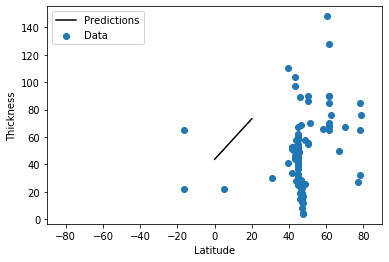

In [21]:
def plot_latitude(x, y):
    plt.scatter(train_features["LAT"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel("Latitude")
    plt.ylabel('Thickness')
    plt.xlim((-90,90))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_latitude(x,y)

# Linear regression with longitude

In [22]:
#put training features into numpy array and apply normalization layer
# array_int = np.array(train_features)
lon = np.array(train_features["LON"])
lon_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lon_normalizer.adapt(lon)

In [23]:
#build latitude model with Sequential
lon_model = tf.keras.Sequential([
    lon_normalizer,
    layers.Dense(1)
])

# area_model.summary()

In [24]:
#more pfm
lon_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [25]:
#run the actual model
#%%time
history_lon = lon_model.fit(
    train_features["LON"], train_labels,
    epochs=100,
    # suppress logging
#    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
3/3 [==============================] - 0s 40ms/step - loss: 48.9077 - val_loss: 56.0515
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 48.6038 - val_loss: 55.7715
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 48.2964 - val_loss: 55.4797
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 47.9900 - val_loss: 55.1929
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 47.6942 - val_loss: 54.9058
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 47.3903 - val_loss: 54.6138
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 47.0853 - val_loss: 54.3199
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 46.7843 - val_loss: 54.0284
Epoch 9/100
3/3 [==============================] - 0s 13ms/step - loss: 46.4840 - val_loss: 53.7378
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 46.1795 - val_loss: 53.4441

3/3 [==============================] - 0s 8ms/step - loss: 28.6453 - val_loss: 34.1796
Epoch 83/100
3/3 [==============================] - 0s 10ms/step - loss: 28.4715 - val_loss: 33.9762
Epoch 84/100
3/3 [==============================] - 0s 10ms/step - loss: 28.2803 - val_loss: 33.7766
Epoch 85/100
3/3 [==============================] - 0s 10ms/step - loss: 28.1028 - val_loss: 33.5740
Epoch 86/100
3/3 [==============================] - 0s 9ms/step - loss: 27.9280 - val_loss: 33.3675
Epoch 87/100
3/3 [==============================] - 0s 9ms/step - loss: 27.7425 - val_loss: 33.1647
Epoch 88/100
3/3 [==============================] - 0s 8ms/step - loss: 27.5686 - val_loss: 32.9705
Epoch 89/100
3/3 [==============================] - 0s 9ms/step - loss: 27.3888 - val_loss: 32.7873
Epoch 90/100
3/3 [==============================] - 0s 9ms/step - loss: 27.2313 - val_loss: 32.6004
Epoch 91/100
3/3 [==============================] - 0s 10ms/step - loss: 27.0740 - val_loss: 32.4099
Epoch 92/

In [26]:
hist_lon = pd.DataFrame(history_lon.history)
hist_lon['epoch'] = history_lon.epoch
hist_lon.tail()

,loss,val_loss,epoch
95,26.299599,31.493557,95
96,26.146166,31.303659,96
97,25.999191,31.108572,97
98,25.857918,30.910492,98
99,25.700657,30.721436,99


In [27]:
lon_test_results = {}

lon_test_results["lon_model"] = lon_model.evaluate(
    test_features["LON"],
    test_labels, verbose=0)

lon_test_results["lon_model"]

30.42522621154785

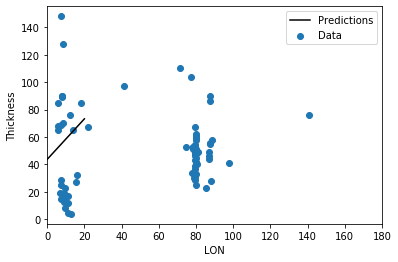

In [28]:
def plot_longitude(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('LON')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_longitude(x,y)

# Multiple inputs

In [29]:
normalizer = preprocessing.Normalization(axis=-1)
multi_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [30]:
multi_model.predict(train_features[:10])

array([[61.342],
       [65.965],
       [29.193],
       [76.655],
       [67.44 ],
       [58.153],
       [66.788],
       [65.264],
       [68.946],
       [64.585]], dtype=float32)

In [31]:
multi_model.layers[1].kernel

<tf.Variable 'dense_3/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.855],
       [ 0.346],
       [ 0.686],
       [-0.432]], dtype=float32)>

In [32]:
multi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
%%time
history_multi = multi_model.fit(
    train_features, train_labels, 
    epochs=300,
    # suppress logging
    #verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/300
3/3 [==============================] - 0s 44ms/step - loss: 21.8566 - val_loss: 21.9206
Epoch 2/300
3/3 [==============================] - 0s 21ms/step - loss: 18.4515 - val_loss: 17.7099
Epoch 3/300
3/3 [==============================] - 0s 12ms/step - loss: 17.0330 - val_loss: 18.2088
Epoch 4/300
3/3 [==============================] - 0s 9ms/step - loss: 16.7864 - val_loss: 17.5429
Epoch 5/300
3/3 [==============================] - 0s 12ms/step - loss: 15.8140 - val_loss: 19.3524
Epoch 6/300
3/3 [==============================] - 0s 12ms/step - loss: 16.2479 - val_loss: 17.7958
Epoch 7/300
3/3 [==============================] - 0s 11ms/step - loss: 15.8670 - val_loss: 17.8251
Epoch 8/300
3/3 [==============================] - 0s 11ms/step - loss: 16.6525 - val_loss: 17.1987
Epoch 9/300
3/3 [==============================] - 0s 12ms/step - loss: 15.9080 - val_loss: 18.3876
Epoch 10/300
3/3 [==============================] - 0s 13ms/step - loss: 15.7087 - val_loss: 17.6974


3/3 [==============================] - 0s 10ms/step - loss: 15.6816 - val_loss: 17.0583
Epoch 83/300
3/3 [==============================] - 0s 10ms/step - loss: 15.7876 - val_loss: 17.1875
Epoch 84/300
3/3 [==============================] - 0s 12ms/step - loss: 15.8170 - val_loss: 17.1608
Epoch 85/300
3/3 [==============================] - 0s 12ms/step - loss: 15.9418 - val_loss: 17.5177
Epoch 86/300
3/3 [==============================] - 0s 11ms/step - loss: 15.8189 - val_loss: 17.2057
Epoch 87/300
3/3 [==============================] - 0s 11ms/step - loss: 15.6693 - val_loss: 18.4275
Epoch 88/300
3/3 [==============================] - 0s 13ms/step - loss: 15.6072 - val_loss: 17.1484
Epoch 89/300
3/3 [==============================] - 0s 11ms/step - loss: 15.7215 - val_loss: 17.1006
Epoch 90/300
3/3 [==============================] - 0s 10ms/step - loss: 15.6150 - val_loss: 18.1325
Epoch 91/300
3/3 [==============================] - 0s 11ms/step - loss: 15.5266 - val_loss: 17.4114
Epo

Epoch 163/300
3/3 [==============================] - 0s 9ms/step - loss: 16.0201 - val_loss: 17.5332
Epoch 164/300
3/3 [==============================] - 0s 11ms/step - loss: 16.0235 - val_loss: 17.6062
Epoch 165/300
3/3 [==============================] - 0s 10ms/step - loss: 15.3530 - val_loss: 18.6153
Epoch 166/300
3/3 [==============================] - 0s 11ms/step - loss: 15.6130 - val_loss: 17.2885
Epoch 167/300
3/3 [==============================] - 0s 12ms/step - loss: 15.3290 - val_loss: 17.2553
Epoch 168/300
3/3 [==============================] - 0s 9ms/step - loss: 15.4035 - val_loss: 17.6984
Epoch 169/300
3/3 [==============================] - 0s 13ms/step - loss: 15.6613 - val_loss: 18.0738
Epoch 170/300
3/3 [==============================] - 0s 11ms/step - loss: 15.5745 - val_loss: 17.3677
Epoch 171/300
3/3 [==============================] - 0s 11ms/step - loss: 16.0417 - val_loss: 17.4259
Epoch 172/300
3/3 [==============================] - 0s 13ms/step - loss: 15.7993 - 

3/3 [==============================] - 0s 10ms/step - loss: 15.3642 - val_loss: 17.4790
Epoch 244/300
3/3 [==============================] - 0s 8ms/step - loss: 15.2482 - val_loss: 17.4227
Epoch 245/300
3/3 [==============================] - 0s 12ms/step - loss: 15.2290 - val_loss: 18.3909
Epoch 246/300
3/3 [==============================] - 0s 11ms/step - loss: 15.4801 - val_loss: 17.6726
Epoch 247/300
3/3 [==============================] - 0s 12ms/step - loss: 15.1377 - val_loss: 17.2148
Epoch 248/300
3/3 [==============================] - 0s 13ms/step - loss: 16.0979 - val_loss: 17.0669
Epoch 249/300
3/3 [==============================] - 0s 12ms/step - loss: 15.6028 - val_loss: 19.0464
Epoch 250/300
3/3 [==============================] - 0s 11ms/step - loss: 15.7474 - val_loss: 18.2913
Epoch 251/300
3/3 [==============================] - 0s 12ms/step - loss: 15.5291 - val_loss: 17.6432
Epoch 252/300
3/3 [==============================] - 0s 10ms/step - loss: 16.2031 - val_loss: 17.

In [34]:
hist_multi = pd.DataFrame(history_multi.history)
hist_multi['epoch'] = history_multi.epoch
hist_multi.tail()

,loss,val_loss,epoch
295,15.109925,17.232431,295
296,15.425486,17.212778,296
297,15.298104,18.488800,297
298,15.740657,18.775494,298
299,15.243864,17.204647,299


In [35]:
#not sure what exactly is going on here but I'm sure this is what needs tweaking
multi_test_results = {}

multi_test_results["multi_model"] = multi_model.evaluate(
    test_features["AREA"],
    test_labels, verbose=0)

multi_test_results["multi_model"]

70.01284790039062

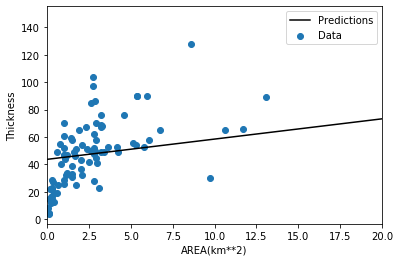

In [36]:
#not sure how to plot different variables on top of each other
#no plot such as this from tutorial

def plot_elevation(x, y):
    plt.scatter(train_features["AREA"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('AREA(km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_elevation(x,y)

# DNN regression

### Single variable

In [37]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [38]:
dnn_area_model = build_and_compile_model(area_normalizer)

In [39]:
dnn_area_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [40]:
%%time
history_dnn = dnn_area_model.fit(
    train_features["AREA"], train_labels,
    validation_split=0.2,
    #verbose=0,
    epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 50ms/step - loss: 48.9262 - val_loss: 56.4453
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 48.8575 - val_loss: 56.3933
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 48.7901 - val_loss: 56.3407
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 48.7193 - val_loss: 56.2873
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 48.6552 - val_loss: 56.2319
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 48.5851 - val_loss: 56.1714
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 48.5080 - val_loss: 56.1050
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 48.4240 - val_loss: 56.0323
Epoch 9/100
3/3 [==============================] - 0s 14ms/step - loss: 48.3346 - val_loss: 55.9516
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 48.2314 - val_loss: 55.8620


3/3 [==============================] - 0s 12ms/step - loss: 18.2074 - val_loss: 21.2337
Epoch 83/100
3/3 [==============================] - 0s 12ms/step - loss: 18.1648 - val_loss: 21.1451
Epoch 84/100
3/3 [==============================] - 0s 10ms/step - loss: 18.1317 - val_loss: 21.0929
Epoch 85/100
3/3 [==============================] - 0s 9ms/step - loss: 18.0977 - val_loss: 21.0285
Epoch 86/100
3/3 [==============================] - 0s 9ms/step - loss: 18.0641 - val_loss: 20.9618
Epoch 87/100
3/3 [==============================] - 0s 10ms/step - loss: 18.0319 - val_loss: 20.9122
Epoch 88/100
3/3 [==============================] - 0s 12ms/step - loss: 18.0019 - val_loss: 20.8696
Epoch 89/100
3/3 [==============================] - 0s 10ms/step - loss: 17.9616 - val_loss: 20.8266
Epoch 90/100
3/3 [==============================] - 0s 11ms/step - loss: 17.9352 - val_loss: 20.7875
Epoch 91/100
3/3 [==============================] - 0s 10ms/step - loss: 17.9034 - val_loss: 20.8241
Epoch

In [41]:
x = tf.linspace(0.0, 250, 251)
y = dnn_area_model.predict(x)

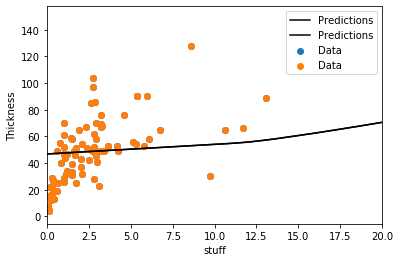

In [42]:

def plot_area(x, y):
    plt.scatter(train_features["AREA"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('stuff')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_area_model.predict(x)
plot_area(x,y)




plot_area(x, y)

In [43]:
dnn_test_results = {}
dnn_test_results['dnn_area_model'] = dnn_area_model.evaluate(
    test_features["AREA"], test_labels,
    verbose=0)

# Full model (not-quite-working)

In [44]:
dnn_full_model = build_and_compile_model(thickness_normalizer)
dnn_full_model.summary()

NameError: name 'thickness_normalizer' is not defined

In [ ]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = dnn_thickness_model.predict(x)

In [ ]:
def plot_thickness(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('bbb')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_full_model.predict(x)
plot_elevation(x,y)




plot_thickness(x, y)

In [ ]:
full_test_results = {}

full_test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features["AREA"],
    test_labels, verbose=0)

full_test_results["dnn_full_model"]